ValueError: 'tab20t' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

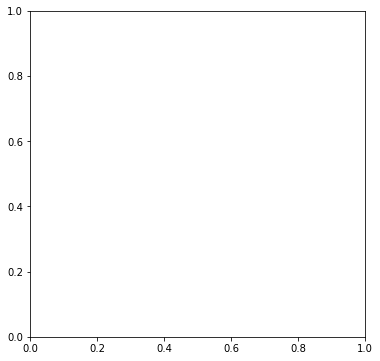

In [194]:
import pandas as pd
import networkx as nx
import numpy as np
import infomap
from matplotlib import pyplot as plt
from matplotlib import colors

df_org = pd.read_csv('data/metadata.csv')

df_intr = pd.read_json('data/cccm_interlocks.json')
df_intr = df_intr[df_intr.Verified]

df_ofc = pd.read_csv('data/officers.csv')

eins = pd.read_csv('data/eins.csv')
ein_to_name = eins.set_index('EIN').ORG
name_to_ein = eins.set_index('ORG').EIN

interlocks = pd.DataFrame(
    [
        {
            'ein1': row.ein1,
            'ein2': row.ein2,
            'year1': y1,
            'year2': y2,
            'strength': np.exp(- abs(y1 - y2))
        }
        for idx, row in df_intr.iterrows()
        for y1 in row.group1Years
        for y2 in row.group2Years
        if not (((y1 == y2) & (row.ein1 == row.ein2)) | y1 < 2003 | y2 < 2003)
    ]
).groupby(['ein1', 'ein2', 'year1', 'year2']).strength.sum().reset_index(drop = False)

edgelist = interlocks.groupby(['ein1', 'ein2']).strength.sum().reset_index(drop = False)
edgelist.columns = ['source', 'target', 'weight']
edgelist['source'] = edgelist.source.map(ein_to_name)
edgelist['target'] = edgelist.target.map(ein_to_name)

edgelist = edgelist[~edgelist.apply(lambda r: 'MECHANICAL' in str(r), 1)]

G = nx.from_pandas_edgelist(edgelist, edge_attr = 'weight')
V = list(G.nodes)

im = infomap.Infomap('--markov-time 0.85 --tree data')
im.add_networkx_graph(G, weight='weight')
im.run()
communities = {V[k]:v for k,v in im.get_modules().items()}
nx.set_node_attributes(G, communities, 'community')

communities_list = [c - 1 for c in nx.get_node_attributes(G, 'community').values()]
num_communities = max(communities_list) + 1

# color map from http://colorbrewer2.org/
cmap = colors.ListedColormap(
    ['#d53e4f','#fc8d59','#fee08b','#e6f598','#99d594','#3288bd'], 'indexed', num_communities)

pos = nx.spring_layout(G, k = 4, iterations = 500, seed = 19012022)
ew = [e[2]['weight']**0.5 for e in G.edges(data = True)] 

fig, ax = plt.subplots(1,1, figsize = (6,6))

nodes = nx.draw_networkx_nodes(G, ax = ax, pos = pos, node_color = communities_list, node_size = 100, cmap = 'tab20t')
nodes.set_edgecolor('k')
edges = nx.draw_networkx_edges(G, ax = ax, pos = pos, width = ew, edge_color = (0,0,0,1))

In [185]:
topics = ['V%i'%i for i in range(1, 51)]

topicprops = pd.read_csv('stm/topicproportions.csv').drop('Unnamed: 0', axis = 1, errors = 'ignore')
docs = pd.read_csv('stm/document_sample.csv').drop(['Unnamed: 0', 'text'], axis = 1, errors = 'ignore')
topiclabels = pd.read_csv('stm/topiclabels.csv').drop('Unnamed: 0', axis = 1)

topiclabels['topic'] = topics
retainedtopics = topiclabels[~topiclabels.remove].topic.values

topicprops['org'] = docs.org
topicprops['year'] = docs.year
topicprops['org_community'] = topicprops.org.map(communities)
topicprops = topicprops.drop(topiclabels[topiclabels.remove].topic, axis = 1)

In [186]:
org_community_topics = topicprops[['org_community', *retainedtopics]].groupby(['org_community'])[retainedtopics].mean().loc[[1,2,3],:].T
org_community_topics['label'] = org_community_topics.index.map(topiclabels.set_index('topic').label)

In [187]:
org_topics = topicprops[['org', *retainedtopics]].groupby(['org'])[retainedtopics].mean().T

In [188]:
A_org_topics = org_topics.corr()
np.fill_diagonal(A_org_topics.values, 0)
A_org_topics.values[A_org_topics.values < 0] = 0

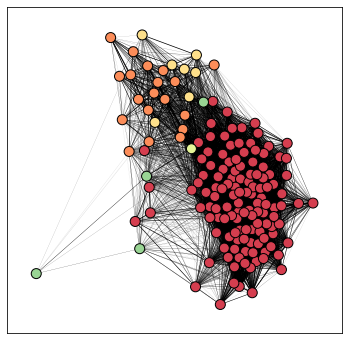

In [199]:
G_org_topics = nx.Graph(A_org_topics)

V = list(G_org_topics.nodes)

im = infomap.Infomap(markov_time = 0.85)
im.add_networkx_graph(G_org_topics, weight='weight')
im.run()
org_topic_communities = {V[k]:v for k,v in im.get_modules().items()}
nx.set_node_attributes(G_org_topics, org_topic_communities, 'community')

G_org_topics.add_nodes_from(eins.ORG.values)

org_topic_communities_list = [G_org_topics.nodes(data=True)[n].get('community')
                    for n in G_org_topics ]

communities_list = [G.nodes(data=True)[n].get('community')if n in G else np.nan
                    for n in G_org_topics ]

# color map from http://colorbrewer2.org/
cmap = colors.ListedColormap(
    ['#d53e4f','#fc8d59','#fee08b','#e6f598','#99d594','#3288bd'], 'indexed', num_communities)


communities_list += [np.nan] * (len(G_org_topics) - len(communities_list))

pos = nx.spring_layout(G_org_topics, k = 4, iterations = 1000, seed = 19012022)

ew = [e[2]['weight'] for e in G_org_topics.edges(data = True)] 

fig, ax = plt.subplots(1,1, figsize = (6,6))

nodes = nx.draw_networkx_nodes(G_org_topics, ax = ax, pos = pos, node_color = org_topic_communities_list, node_size = 100, cmap = cmap)
nodes.set_edgecolor('k')
edges = nx.draw_networkx_edges(G_org_topics, ax = ax, pos = pos, width = ew, edge_color = (0,0,0,1))

NodeDataView({'AMERICAN INSTITUTE FOR ECONOMIC RESEARCH': {'community': 1}, 'FREE TO CHOOSE NETWORK': {'community': 1}, 'NATIONAL ASSOCIATION OF SCHOLARS': {'community': 1}, 'NATIONAL TAXPAYERS UNION': {'community': 1}, 'NATIONAL TAXPAYERS UNION FOUNDATION': {'community': 1}, 'TEXAS PUBLIC POLICY FOUNDATION': {'community': 1}, 'AMERICAN GAS ASSOCIATION': {'community': 2}, 'EDISON ELECTRIC INSTITUTE': {'community': 2}, 'INTERSTATE NATURAL GAS ASSOCIATION OF AMERICA': {'community': 2}, 'AMERICAN PETROLEUM INSTITUTE': {'community': 3}, 'NATIONAL ASSOCIATION OF MANUFACTURERS': {'community': 2}, 'NATIONAL MINING ASSOCIATION': {'community': 2}, 'NATIONAL RURAL ELECTRIC COOPERATIVE ASSOCIATION': {'community': 3}, 'INDEPENDENT PETROLEUM ASSOCIATION OF AMERICA': {'community': 3}, 'PETROLEUM ALLIANCE OF OKLAHOMA THE': {'community': 3}, 'WESTERN STATES PETROLEUM ASSOCIATION': {'community': 3}, 'HUDSON INSTITUTE': {'community': 1}, 'MANHATTAN INSTITUTE FOR POLICY RESEARCH': {'community': 1}, 'NATI

In [133]:
pd.Series(communities).groupby(communities).apply(print)

ACCURACY IN ACADEMIA                                     1
ACCURACY IN MEDIA                                        1
ACTON INSTITUTE FOR THE STUDY OF RELIGION AND LIBERTY    1
ADVOCATES FOR SELF GOVERNMENT                            1
ALASKA POLICY FORUM                                      1
                                                        ..
WASHINGTON POLICY CENTER                                 1
WYOMING LIBERTY GROUP                                    1
YANKEE INSTITUTE FOR PUBLIC POLICY                       1
YOUNG AMERICA'S FOUNDATION                               1
YOUNG AMERICANS FOR LIBERTY                              1
Name: 1, Length: 125, dtype: int64
AMERICAN ASSOCIATION OF PETROLEUM GEOLOGISTS       2
AMERICAN EXPLORATION & PRODUCTION COUNCIL          2
AMERICAN FUEL AND PETROCHEMICAL MANUFACTURERS      2
AMERICAN GAS ASSOCIATION                           2
AMERICAN PETROLEUM INSTITUTE                       2
CENTER FOR LIQUEFIED NATURAL GAS                   

1    None
2    None
3    None
4    None
5    None
6    None
dtype: object

In [67]:
T = nx.Graph(np.log(topicprops[retainedtopics]).corr())

im = infomap.Infomap()
im.add_networkx_graph(T, weight='weight')
im.run()
topic_communities = {[*T.nodes][k]:v for k,v in im.get_modules().items()}
nx.set_node_attributes(T, topic_communities, 'community')

In [68]:
topiclabels['topic_community'] = topiclabels.topic.map(topic_communities)

In [69]:
topiclabels

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,label,grouplabel,remove,topic,topic_community
0,china,countri,unit,world,state,europ,european,power,india,war,geopolitics,NaN,False,V1,2.0
1,march,april,releas,juli,june,januari,septemb,letter,novemb,decemb,months,NaN,True,V2,NaN
2,tax,carbon,credit,revenu,propos,rais,incom,increas,fee,rate,carbon_tax,NaN,False,V3,1.0
3,energi,associ,inc,ohio,servic,compani,washington,north,american,state,energy_firm,NaN,False,V4,1.0
4,carbon,dioxid,atmospher,concentr,plant,increas,air,effect,water,earth,co2_concentration,NaN,False,V5,2.0
5,fuel,vehicl,car,transport,standard,gasolin,engin,use,truck,diesel,car_fuel,NaN,False,V6,1.0
6,institut,polici,center,research,foundat,public,nation,environment,director,senior,research_institute,NaN,True,V7,NaN
7,temperatur,model,warm,climat,data,increas,trend,global,period,observ,warming,NaN,False,V8,2.0
8,will,need,develop,energi,econom,futur,technolog,world,continu,growth,energy_development,NaN,False,V9,1.0
9,per,percent,year,total,million,billion,averag,ton,figur,annual,numbers,NaN,True,V10,NaN
